## Sagnac Frequency - Compare Drift of Rings

## Imports

In [41]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert


In [42]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

In [43]:
# from functions.load_beat import __load_beat
from functions.load_sagnac_beat_data import __load_sagnac_beat_data
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN
from functions.load_mlti import __load_mlti
from functions.smoothing import __smooth
from functions.interpolate_nan import __interpolate_nan

## Configurations

In [44]:
config = {}

# case = 20
# config['tbeg'] = UTCDateTime("2024-03-09 00:00")
# config['tend'] = UTCDateTime("2024-04-09 00:00")
# Zlower, Zupper = 553.542, 553.564
# Ulower, Uupper = 302.40, 302.50
# Vlower, Vupper = 447.725, 447.74

# case = 21
# config['tbeg'] = UTCDateTime("2023-12-01 00:00")
# config['tend'] = UTCDateTime("2023-12-31 00:00")
# Zlower, Zupper = 553.49, 553.51
# Ulower, Uupper = 302.4, 302.52
# Vlower, Vupper = 447.42, 447.46

# case = 22
# config['tbeg'] = UTCDateTime("2024-02-09 00:00")
# config['tend'] = UTCDateTime("2024-02-12 12:00")
# Zlower, Zupper = 553.555, 553.565
# Ulower, Uupper = 302.40, 302.45
# Vlower, Vupper = 447.745, 447.755

# case = 23
# config['tbeg'] = UTCDateTime("2024-01-01 00:00")
# config['tend'] = UTCDateTime("2024-02-20 00:00")
# Zlower, Zupper = 553.48, 553.58
# Ulower, Uupper = 302.39, 302.475
# Vlower, Vupper = 447.7, 447.80

# case = 24
# config['tbeg'] = UTCDateTime("2023-12-01 00:00")
# config['tend'] = UTCDateTime("2024-01-15 00:00")
# Zlower, Zupper = 553.49, 553.51
# Ulower, Uupper = 302.4, 302.52
# Vlower, Vupper = 447.42, 447.46

# case = 30 # longterm 2024
# config['tbeg'] = UTCDateTime("2024-01-23 00:00")
# config['tend'] = UTCDateTime("2024-06-23 00:00")
# Zlower, Zupper = 553.52, 553.58
# Ulower, Uupper = 302.4, 302.48
# Vlower, Vupper = 447.72, 447.78

# case = 25 # water
# config['tbeg'] = UTCDateTime("2024-05-29 00:00")
# config['tend'] = UTCDateTime("2024-06-05 00:00")
# Zlower, Zupper = 553.52, 553.58
# Ulower, Uupper = 302.40, 302.47
# Vlower, Vupper = 447.72, 447.78

case = 26
config['tbeg'] = UTCDateTime("2024-07-06 00:00")
config['tend'] = UTCDateTime("2024-07-17 00:00")
Zlower, Zupper = 553.52, 553.58
Ulower, Uupper = 302.4, 302.48
Vlower, Vupper = 447.72, 447.78


config['path_to_sds'] = archive_path+"romy_archive/"

# path to Sagnac Beat data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

In [45]:
beatU = __load_sagnac_beat_data(config['tbeg'], config['tend'], "U", config['path_to_autodata'])
beatZ = __load_sagnac_beat_data(config['tbeg'], config['tend'], "Z", config['path_to_autodata'])
beatV = __load_sagnac_beat_data(config['tbeg'], config['tend'], "V", config['path_to_autodata'])

In [46]:
# read_pickle(archive_path+"romy_autodata/2024/RU/FJU_20240301.pkl")

In [47]:
def __makeplot0(beat1, beat2, beat3, key, limits=True):

    Nrow, Ncol = 3, 1

    font = 12

    time_scaling = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beat1.times_utc_sec*time_scaling, beat1[key])
    # ax[0].set_ylim(553.49, 553.52)
    ax[0].ticklabel_format(useOffset=False)

    ax[1].plot(beat2.times_utc_sec*time_scaling, beat2[key])
    # ax[1].set_ylim(302.4, 302.5)
    ax[1].ticklabel_format(useOffset=False)

    ax[2].plot(beat3.times_utc_sec*time_scaling, beat3[key])
    # ax[2].set_ylim(447.4, 447.6)
    ax[2].ticklabel_format(useOffset=False)

    # ax[2].axhline(np.nanpercentile(beatV.fj, 99))
    # ax[2].axhline(np.nanpercentile(beatV.fj, 1))

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    if limits:
        ax[0].set_ylim(Zlower, Zupper)
        ax[1].set_ylim(Ulower, Uupper)
        ax[2].set_ylim(Vlower, Vupper)

    plt.show();
    return fig

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


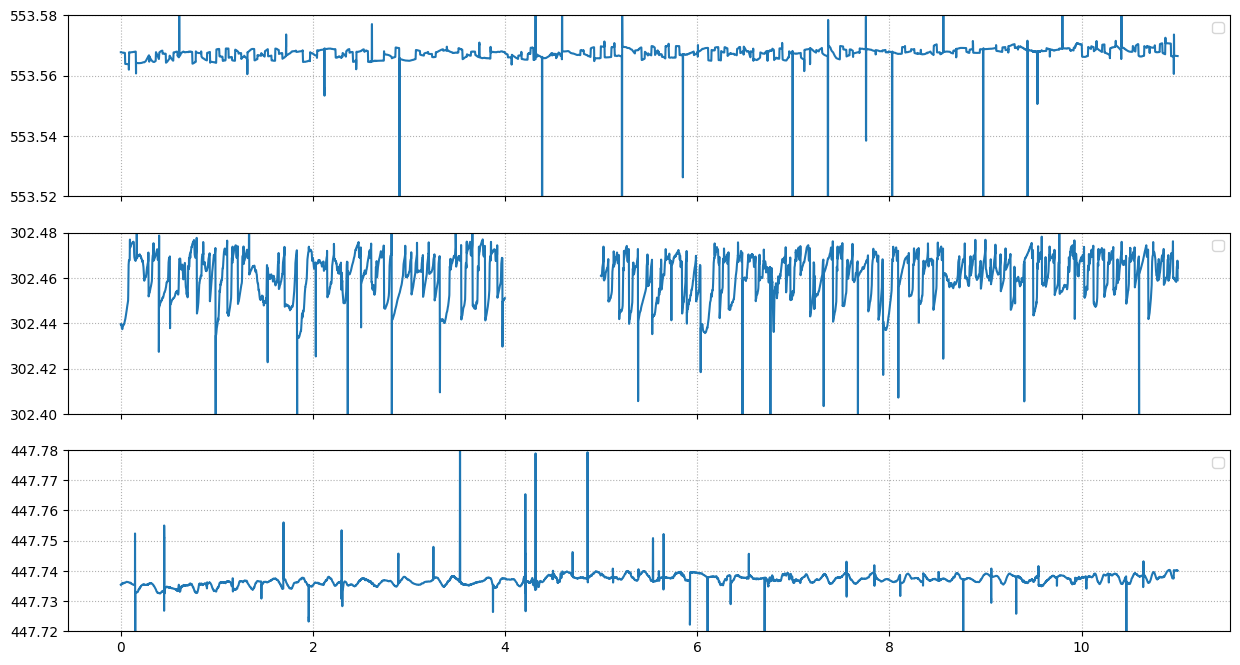

In [48]:
fig = __makeplot0(beatZ, beatU, beatV, "fj");

## find jumps

In [49]:
from functions.get_phase_jumps_sta_lta import get_phase_jumps_sta_lta

In [50]:
def __reduce_phase_jumps(data, detect):

    data = np.array(data)

    for _i in range(len(data)):

        if detect[_i] == 1:
            left = np.nanmean(data[_i-8:_i-3])
            right = np.nanmean(data[_i+3:_i+8])

            diff = left - right

            data[_i-3:_i] = left

            data[_i:] += diff

    return data

In [51]:
ratio, detect = get_phase_jumps_sta_lta(np.array(beatU.fj), np.array(beatU.times_utc_sec),
                                        5, 3, amp_threshold=0.0001, plot=False)

beatU['fj_dj'] = __reduce_phase_jumps(beatU.fj, detect)

ratio, detect = get_phase_jumps_sta_lta(np.array(beatV.fj), np.array(beatV.times_utc_sec),
                                        5, 3, amp_threshold=0.0001, plot=False)

beatV['fj_dj'] = __reduce_phase_jumps(beatV.fj, detect)

ratio, detect = get_phase_jumps_sta_lta(np.array(beatZ.fj), np.array(beatZ.times_utc_sec),
                                        5, 3, amp_threshold=0.0001, plot=False)

beatZ['fj_dj'] = __reduce_phase_jumps(beatZ.fj, detect)


/home/brotzer/notebooks/SagnacFrequency/functions/get_phase_jumps_sta_lta.py:22: RuntimeWarning: Mean of empty slice
  STA = np.nanmean(abs(_data[n-int(ST):n]))
/home/brotzer/notebooks/SagnacFrequency/functions/get_phase_jumps_sta_lta.py:21: RuntimeWarning: Mean of empty slice
  LTA = np.nanmean(abs(_data[n-int(LT):n]))
/tmp/ipykernel_1273327/1803006287.py:9: RuntimeWarning: Mean of empty slice
  right = np.nanmean(data[_i+3:_i+8])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


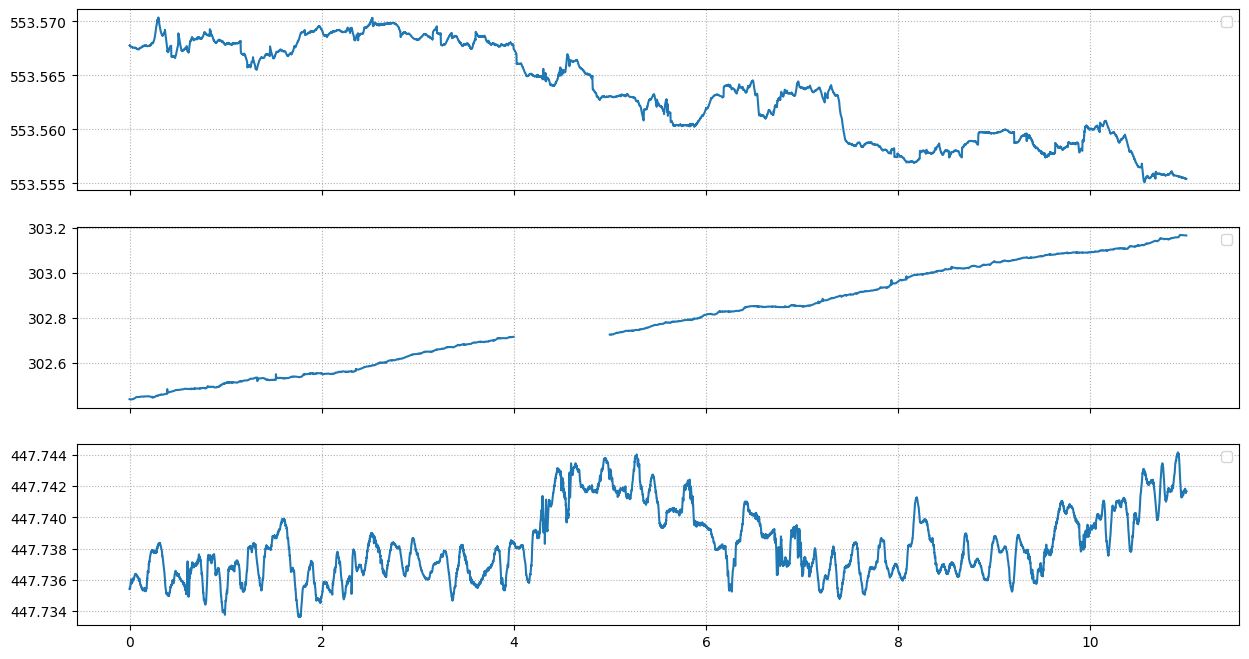

In [52]:
fig = __makeplot0(beatZ, beatU, beatV, "fj_dj", limits=False);

## Remove breakdown periods

In [53]:
timesU = [("2023-12-04T09:10", "2023-12-04T18:02"),
          ("2023-12-20T06:10", "2023-12-20T12:01")]

for t1, t2 in timesU:
    beatU['fj'] = np.where((beatU.times_utc > t1) & (beatU.times_utc < t2), np.nan, beatU['fj'])

# beatU['fj'] = np.nan_to_num(beatU['fj'], nan=np.nanmedian(beatU['fj']))

In [54]:
timesV = [("2024-01-01T04:00", "2024-01-01T22:51"),
          ("2024-01-03T14:20", "2024-01-06T00:00"),
          ("2023-12-19T09:40", "2023-12-19T15:21")]

for t1, t2 in timesV:
    beatV['fj'] = np.where((beatV.times_utc > t1) & (beatV.times_utc < t2), np.nan, beatV['fj'])

# beatV['fj'] = np.nan_to_num(beatV['fj'], nan=np.nanmedian(beatV['fj']))

In [55]:
# plt.plot(beatZ[(beatZ.times_utc > "2024-06-03 02:00") & (beatZ.times_utc < "2024-06-23 00:00")].fj)

In [56]:
timesZ = [("2023-12-07T00:10", "2023-12-08T18:05"),
          ("2024-05-30T14:00", "2024-06-02T15:00"),
          ("2024-06-03 02:00", "2024-06-23 00:00"),]

for t1, t2 in timesZ:
    beatZ['fj'] = np.where((beatZ.times_utc > t1) & (beatZ.times_utc < t2), np.nan, beatZ['fj'])

# beatZ['fj'] = np.nan_to_num(beatZ['fj'], nan=np.nanmedian(beatZ['fj']))

### Exclude Outliers

In [57]:
beatZ['fj'] = np.where((beatZ.fj > Zupper), np.nan, beatZ.fj)
beatZ['fj'] = np.where((beatZ.fj < Zlower), np.nan, beatZ.fj)

beatU['fj'] = np.where((beatU.fj > Uupper), np.nan, beatU.fj)
beatU['fj'] = np.where((beatU.fj < Ulower), np.nan, beatU.fj)

beatV['fj'] = np.where((beatV.fj > Vupper), np.nan, beatV.fj)
beatV['fj'] = np.where((beatV.fj < Vlower), np.nan, beatV.fj)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


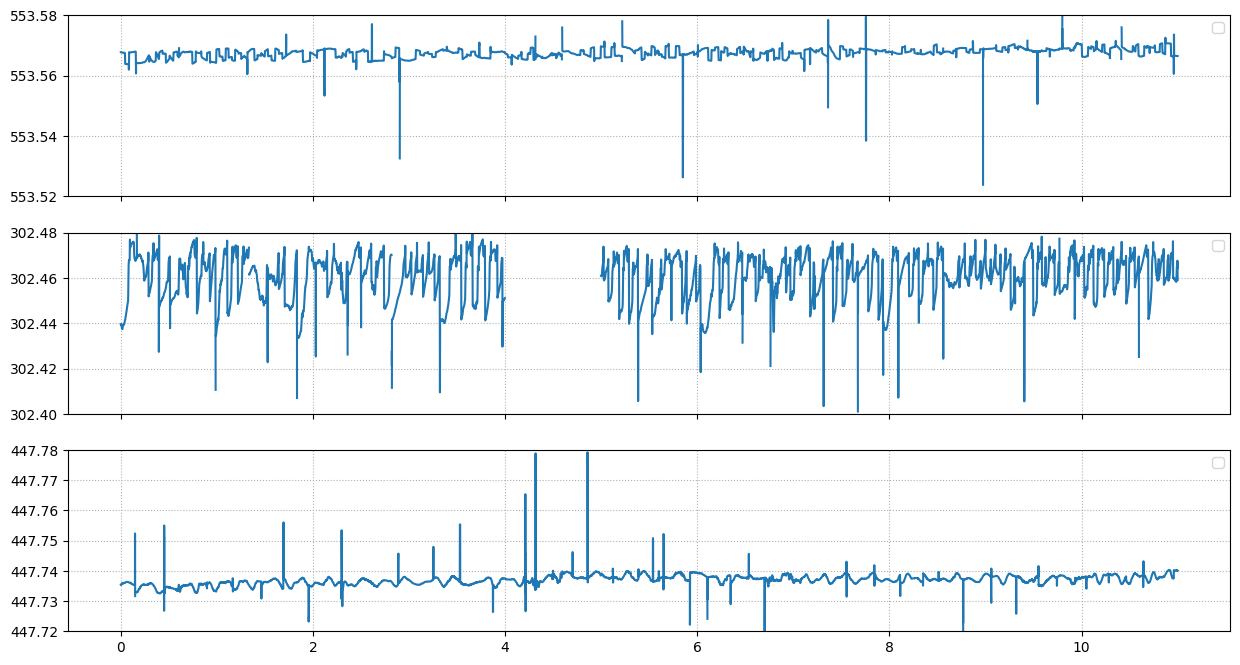

In [58]:
fig = __makeplot0(beatZ, beatU, beatV, "fj");

## Load Maintenance LXX log

In [59]:
from functions.load_lxx import __load_lxx
from functions.get_lxx_intervals import __get_lxx_intervals

# load LXX log data
lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

# extract time intervals
lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)


## Remove MLTI times

In [60]:
mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

mltiZ = __load_mlti(config['tbeg'], config['tend'], "Z", archive_path)

mltiV = __load_mlti(config['tbeg'], config['tend'], "V", archive_path)

In [61]:
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

mltiZ_t1, mltiZ_t2 = __get_mlti_intervals(mltiZ.time_utc)

mltiV_t1, mltiV_t2 = __get_mlti_intervals(mltiV.time_utc)

In [62]:
from functions.get_mlti_statistics import __get_mlti_statistics

In [63]:
def __get_mlti_statistics(mlti, starttime, endtime, plot=True, ylog=False):

    import numpy as np
    import matplotlib.pyplot as plt
    from obspy import UTCDateTime

    # convert to array with UTCDateTime objects
    mlti_times = np.array([UTCDateTime(_t) for _t in mlti.time_utc])

    # relative time in seconds
    mlti_times_sec = np.array(mlti_times - starttime)

    # timeline in seconds
    times_sec = np.array(np.arange(0, UTCDateTime(endtime)-UTCDateTime(starttime), 1))

    # start mlti array
    _mlti = np.zeros(len(times_sec))

    # switch 0 to 1 for each mlti time
    _t0 = 0
    for _m in mlti_times_sec:
        for _j, _t in enumerate(times_sec):
            if _t < _t0:
                continue
            if _t >= _m:
                _mlti[_j] = 1
                _t0 = _t
                break

    # sum it up
    mlti_cumsum = np.cumsum(_mlti)

    # to percent
    mlti_cumsum = mlti_cumsum
    mlti_cumsum_percent = mlti_cumsum / max(mlti_cumsum) * 100

    # inter mlti times
    mlti_times_sec_shift = np.roll(mlti_times_sec, 1)
    mlti_times_sec_shift[0] = 0
    mlti_inter_sec = mlti_times_sec - mlti_times_sec_shift

    # plotting
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

        ax[0].plot(times_sec/86400, mlti_cumsum_percent)
        ax[1].hist(mlti_inter_sec/3600, bins=int(24/1), range=(0, 24), rwidth=0.8)

        if ylog:
            ax[1].set_yscale("log")

        ax[0].grid(color="grey", ls="--", alpha=0.4)
        ax[1].grid(color="grey", ls="--", alpha=0.4)

        ax[0].set_xlabel("Time (days)", fontsize=12)
        ax[0].set_ylabel("MLTI Count (%)", fontsize=12)

        ax[1].set_xlabel("Inter-MLTI-Time (hours)", fontsize=12)
        ax[1].set_ylabel("MLTI Count", fontsize=12)

        plt.show();

    output = {"cumsum":mlti_cumsum,
              "cumsumsec":mlti_cumsum*30,
              "cumsump":mlti_cumsum_percent,
              "intersec":mlti_inter_sec,
              "tsec":times_sec,
              "mlti_series":_mlti
             }

    return output

In [64]:
mltistats = {}

mltistats["U"] = __get_mlti_statistics(mltiU, config['tbeg'], config['tend'], plot=False, ylog=False)

mltistats["V"] = __get_mlti_statistics(mltiV, config['tbeg'], config['tend'], plot=False, ylog=False)

mltistats["Z"] = __get_mlti_statistics(mltiZ, config['tbeg'], config['tend'], plot=False, ylog=False)

In [65]:
# plt.plot(__smooth(data["Z"]["mlti_series"], 8640))
# plt.plot(__smooth(data["U"]["mlti_series"], 8640))
# plt.plot(__smooth(data["V"]["mlti_series"], 8640))

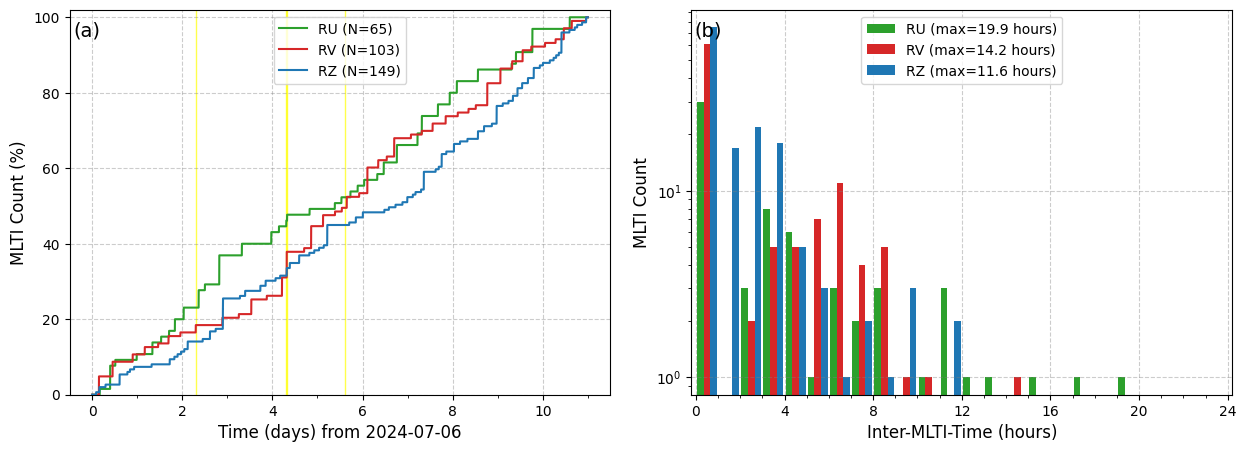

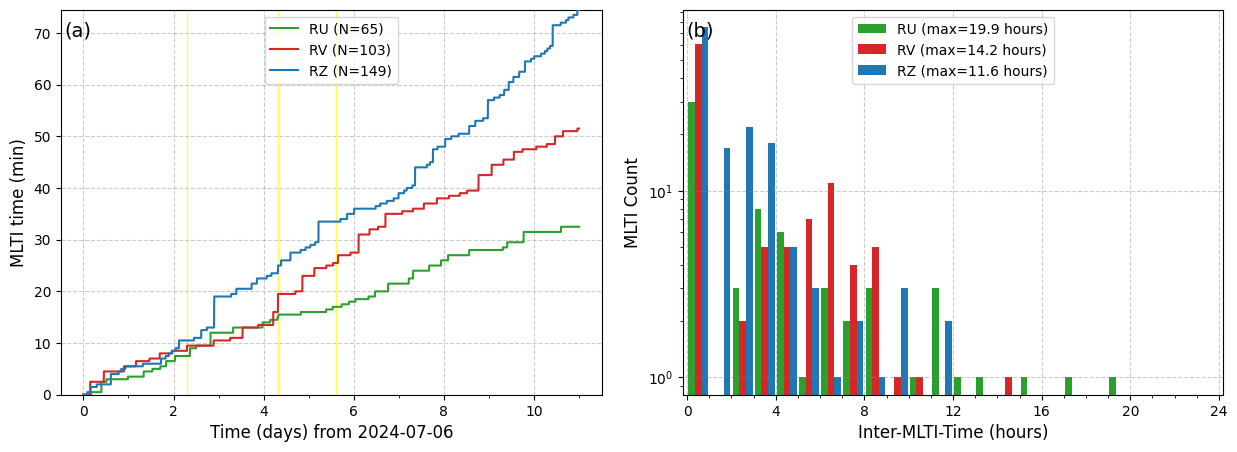

In [66]:
def __makeplot_mlti_statistics(data, ylog=False, sec=False):

    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    tscale = 1/86400

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    plt.subplots_adjust(wspace=0.15)

    colors = {"Z":"tab:blue", "U":"tab:green", "V":"tab:red"}

    s_max = []
    for r in data.keys():
        s_max.append(max(data[r]["cumsumsec"]))
    s_max = max(s_max)

    if s_max > 3600:
        sscale, sunit = 1/60, "min"
    elif s_max > 86400:
        sscale, sunit = 1/3600, "hour"
    else:
        sscale, sunit = 1, "s"

    offset = [-0.3, 0, 0.3]
    for _i, r in enumerate(data.keys()):

        n = data[r]["cumsum"][-1].astype(int)

        if sec:
            ax[0].plot(data[r]["tsec"]*tscale, data[r]["cumsumsec"]*sscale, label=f"R{r} (N={n})", color=colors[r], zorder=3)
            ax[0].set_ylim(0, s_max*sscale)
            ax[0].set_ylabel(f"MLTI time ({sunit})", fontsize=12)
        else:
            ax[0].plot(data[r]["tsec"]*tscale, data[r]["cumsump"], label=f"R{r} (N={n})", color=colors[r], zorder=3)
            ax[0].set_ylim(0, 102)
            ax[0].set_ylabel("MLTI Count (%)", fontsize=12)

        imax = round(max(data[r]["intersec"]/3600), 1)
        h, b = np.histogram(data[r]["intersec"]/3600, bins=int(24/1), range=(0, 24))
        bins = b[:-1] + b[1]/2 + offset[_i]
        ax[1].bar(bins, h, width=0.3, color=colors[r], label=f"R{r} (max={imax} hours)")

    if ylog:
        ax[1].set_yscale("log")

    ax[0].set_xlim(0-0.5, max(data[r]["tsec"]*tscale)+0.5)
    ax[1].set_xlim(0-0.2, 24+0.2)

    ax[0].legend(loc=9)
    ax[1].legend(loc=9)

    ax[0].grid(color="grey", ls="--", alpha=0.4)
    ax[1].grid(color="grey", ls="--", alpha=0.4)

    ax[0].set_xlabel(f"Time (days) from {config['tbeg'].date}", fontsize=12)

    ax[1].set_xlabel("Inter-MLTI-Time (hours)", fontsize=12)
    ax[1].set_ylabel("MLTI Count", fontsize=12)

    ax[0].xaxis.set_major_locator(MultipleLocator(2))
    ax[0].xaxis.set_minor_locator(MultipleLocator(1))
    ax[1].xaxis.set_major_locator(MultipleLocator(4))
    ax[1].xaxis.set_minor_locator(MultipleLocator(1))

    for _k, ll in enumerate(['(a)', '(b)']):
        ax[_k].text(.006, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=14)

    # add maintenance times
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = (lx1-UTCDateTime(config['tbeg']))*tscale
        lx2_sec = (lx2-UTCDateTime(config['tbeg']))*tscale
        ax[0].fill_betweenx([-10000, 10000], lx1_sec, lx2_sec, color="yellow", alpha=0.7)


    plt.show();
    return fig

fig = __makeplot_mlti_statistics(mltistats, ylog=True, sec=False)

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_mlti_statistics.png", format="png", dpi=150, bbox_inches='tight')

fig = __makeplot_mlti_statistics(mltistats, ylog=True, sec=True)

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_mlti_statistics_secs.png", format="png", dpi=150, bbox_inches='tight')



### Set MLTI intervals to NaN

In [67]:
beatU = __mlti_intervals_to_NaN(beatU, "fj", "times_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)
beatV = __mlti_intervals_to_NaN(beatV, "fj", "times_utc", mltiV_t1, mltiV_t2, t_offset_sec=180)
beatZ = __mlti_intervals_to_NaN(beatZ, "fj", "times_utc", mltiZ_t1, mltiZ_t2, t_offset_sec=180)

## Interpolate NaN values

In [68]:
beatU['fj_inter'] = __interpolate_nan(np.array(beatU.fj_nan))
beatV['fj_inter'] = __interpolate_nan(np.array(beatV.fj_nan))
beatZ['fj_inter'] = __interpolate_nan(np.array(beatZ.fj_nan))

## Smoothing

In [69]:
n_minutes = 24*60

beatU['fj_smooth'] = __smooth(beatU.fj_inter, n_minutes)
beatV['fj_smooth'] = __smooth(beatV.fj_inter, n_minutes)
beatZ['fj_smooth'] = __smooth(beatZ.fj_inter, n_minutes)

beatU['fj_dj_smooth'] = __smooth(beatU.fj_dj, n_minutes)
beatV['fj_dj_smooth'] = __smooth(beatV.fj_dj, n_minutes)
beatZ['fj_dj_smooth'] = __smooth(beatZ.fj_dj, n_minutes)

from scipy.ndimage import gaussian_filter1d

# n = 180

# beatU['fj_smooth'] = gaussian_filter1d(beatU.fj_inter, n)
# beatV['fj_smooth'] = gaussian_filter1d(beatV.fj_inter, n)
# beatZ['fj_smooth'] = gaussian_filter1d(beatZ.fj_inter, n)

# beatU['fj_dj_smooth'] = gaussian_filter1d(beatU.fj_dj, n)
# beatV['fj_dj_smooth'] = gaussian_filter1d(beatV.fj_dj, n)
# beatZ['fj_dj_smooth'] = gaussian_filter1d(beatZ.fj_dj, n)

## Masks

In [70]:
maskU = np.where(np.isnan(beatU.fj_nan), np.nan, 1)
maskV = np.where(np.isnan(beatV.fj_nan), np.nan, 1)
maskZ = np.where(np.isnan(beatZ.fj_nan), np.nan, 1)

In [71]:
beatU['fj_smooth_masked'] = beatU['fj_smooth'] * maskU
beatV['fj_smooth_masked'] = beatV['fj_smooth'] * maskV
beatZ['fj_smooth_masked'] = beatZ['fj_smooth'] * maskZ

## Plotting

In [30]:
# Zlower, Zupper = 553.50, 553.60
# Ulower, Uupper = 302.39, 302.49
# Vlower, Vupper = 447.70, 447.80

/tmp/ipykernel_1273327/1112775776.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[Nrow-1].set_xticklabels(tcklbls)


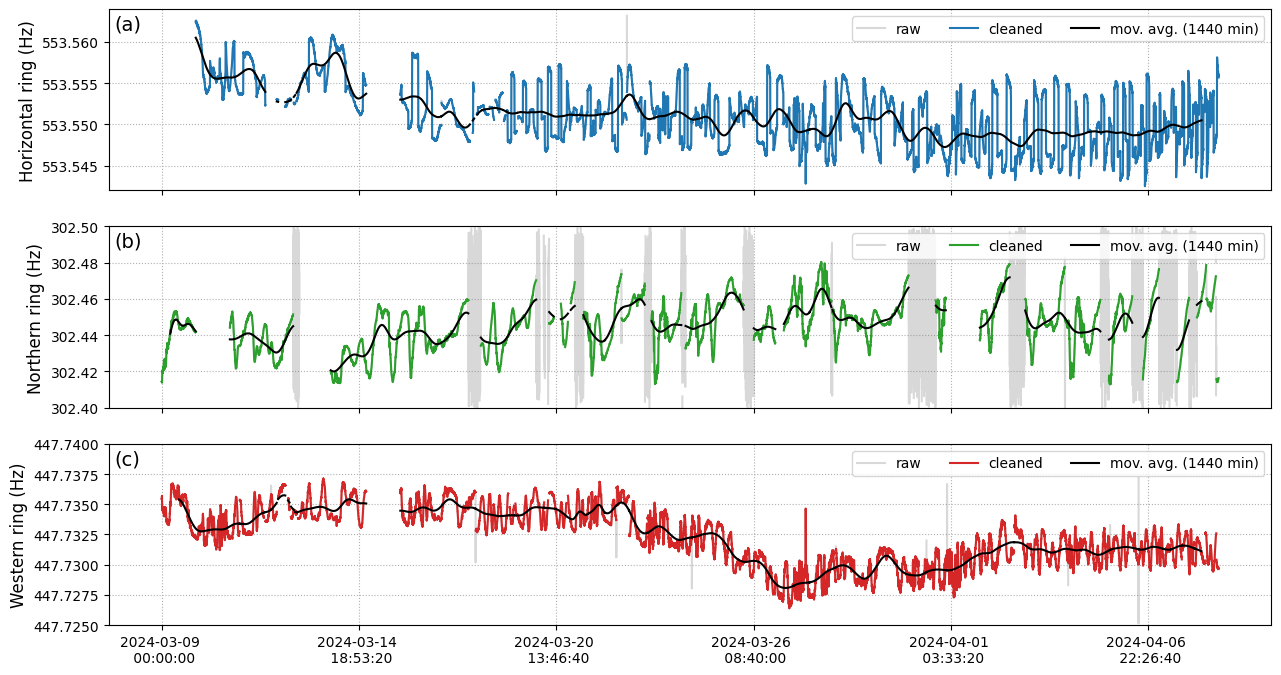

In [31]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    ref_date = UTCDateTime(str(beatV.times_utc.iloc[0])[:10])

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    # time_scaling = 1/86400
    time_scaling = 1

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_nan, color="tab:blue", label="cleaned")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_smooth_masked, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[0].set_ylim(Zlower, Zupper)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("Horizontal ring (Hz)", fontsize=font)

    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_nan, color="tab:green", label="cleaned")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_smooth_masked, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[1].set_ylim(Ulower, Uupper)
    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylabel("Northern ring (Hz)", fontsize=font)

    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_nan, color="tab:red", label="cleaned")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_smooth_masked, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[2].set_ylim(Vlower, Vupper)
    ax[2].set_ylim()

    ax[2].ticklabel_format(useOffset=False)
    ax[2].set_ylabel("Western ring (Hz)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax[_n].fill_betweenx([-1000, 1000], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    # add subplot labels
    for _k, ll in enumerate(['(a)', '(b)', '(c)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_smoothed.png", format="png", dpi=150, bbox_inches='tight')


In [32]:
Zlower2, Zupper2 = 553.557, 553.574
Ulower2, Uupper2 = 302.435, 303.150
Vlower2, Vupper2 = 447.730, 447.746

KeyError: 'Z'

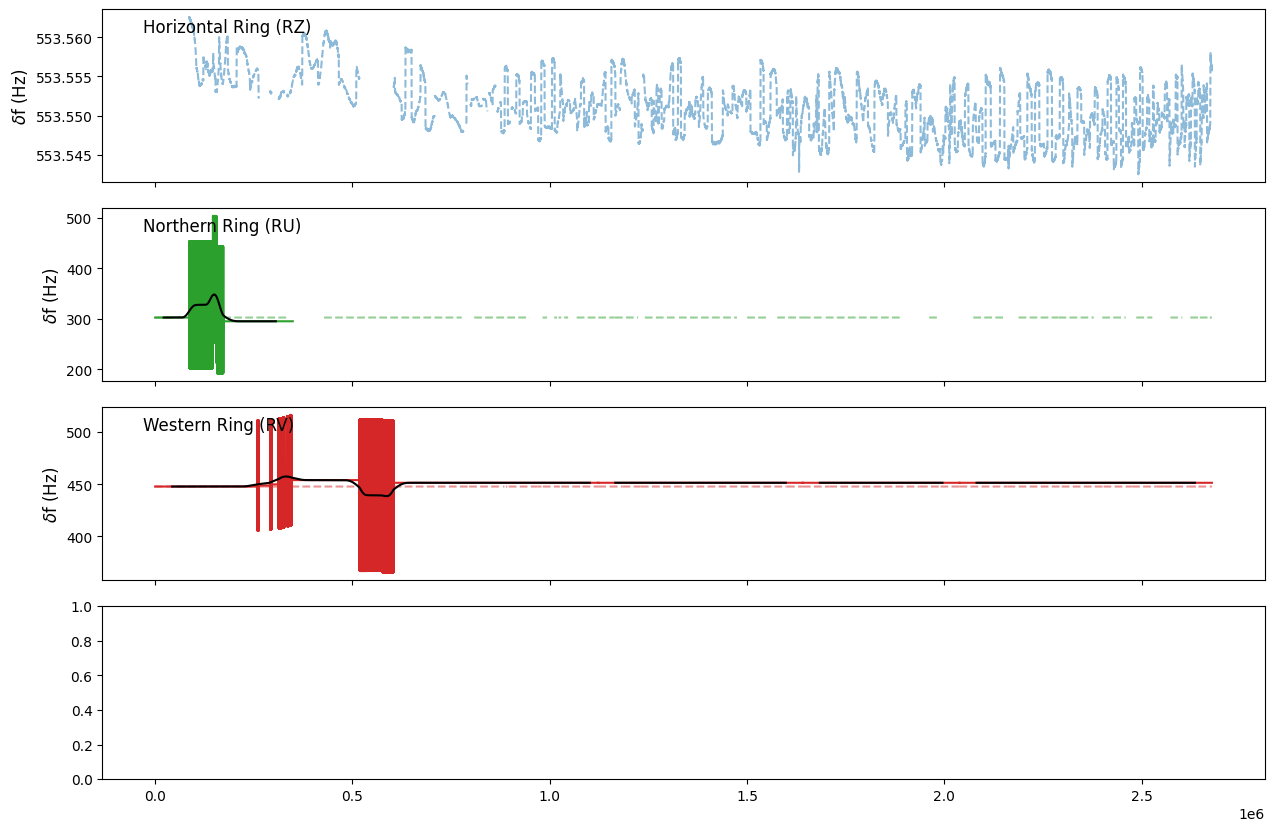

In [33]:
def __makeplot():

    Nrow, Ncol = 4, 1

    font = 12

    ref_date = UTCDateTime(str(beatV.times_utc.iloc[0])[:10])
    ref_date = config['tbeg']

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.15)

    # time_scaling = 1/86400
    time_scaling = 1

    # ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_nan, color="tab:blue", label="clean", ls="--", alpha=0.5)
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_dj, color="tab:blue", label="dejump")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_dj_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel(r"$\delta$f (Hz)", fontsize=font)
    ax[0].text(.035, .95, "Horizontal Ring (RZ)", ha='left', va='top', transform=ax[0].transAxes, fontsize=font)

    # ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_nan, color="tab:green", label="clean", ls="--", alpha=0.5)
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_dj, color="tab:green", label="dejump")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_dj_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylabel(r"$\delta$f (Hz)", fontsize=font)
    ax[1].text(.035, .95, "Northern Ring (RU)", ha='left', va='top', transform=ax[1].transAxes, fontsize=font)

    # ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_nan, color="tab:red", label="clean", ls="--", alpha=0.5)
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_dj, color="tab:red", label="dejump")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_dj_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[2].set_ylabel(r"$\delta$f (Hz)", fontsize=font)
    ax[2].text(.035, .95, "Western Ring (RV)", ha='left', va='top', transform=ax[2].transAxes, fontsize=font)

    ax[2].ticklabel_format(useOffset=False)
    ax[2].set_ylabel("$\delta$f (Hz)", fontsize=font)

    n_rz, n_ru, n_rv = int(mltistats['Z']['cumsum'][-1]), int(mltistats['U']['cumsum'][-1]), int(mltistats['V']['cumsum'][-1])
    ax[3].plot(mltistats['Z']['tsec']*time_scaling, mltistats['Z']['cumsump'], color="tab:blue", label=f"RZ (N={n_rz})")
    ax[3].plot(mltistats['U']['tsec']*time_scaling, mltistats['U']['cumsump'], color="tab:green", label=f"RU (N={n_ru})")
    ax[3].plot(mltistats['V']['tsec']*time_scaling, mltistats['V']['cumsump'], color="tab:red", label=f"RV (N={n_rv})")
    # ax[3].set_yscale("log")
    # ax[3].set_ylim(0, max([n_rz, n_rv, n_ru])+2)
    ax[3].set_ylim(0, 102)
    ax[3].set_ylabel("MLTI Count (%)", fontsize=font)

    ax[0].set_ylim(Zlower2, Zupper2)
    ax[1].set_ylim(Ulower2, Uupper2)
    ax[2].set_ylim(Vlower2, Vupper2)


    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=9, ncol=4)

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax[_n].fill_betweenx([-1000, 1000], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    # add subplot labels
    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_dejump_smoothed.png", format="png", dpi=150, bbox_inches='tight')


## Rotate to ZNE

In [ ]:
from functions.reduce import __reduce

key = "fj_smooth"
key = "fj_dj_smooth"

beatU['fj_reduced'] = __reduce(beatU[key], 60)
beatV['fj_reduced'] = __reduce(beatV[key], 60)
beatZ['fj_reduced'] = __reduce(beatZ[key], 60)

beatU['fj_reduced_masked'] = beatU['fj_reduced'] * maskU
beatV['fj_reduced_masked'] = beatV['fj_reduced'] * maskV
beatZ['fj_reduced_masked'] = beatZ['fj_reduced'] * maskZ

In [34]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    ref_date = UTCDateTime(str(beatZ.times_utc.iloc[0])[:10])

    time_scaling = 1
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_reduced, color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV.fj_reduced, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    ax[0].plot(beatU.times_utc_sec*time_scaling, beatU.fj_reduced, color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta f$ (Hz)", fontsize=font)


    # ax[1].plot(beatZ.times_utc_sec*time_scaling, beatZ.tilt_reduced*tilt_scaling, color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    # ax[1].plot(beatV.times_utc_sec*time_scaling, beatV.tilt_reduced*tilt_scaling, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    # ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.tilt_reduced*tilt_scaling, color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")

    ax[1].plot(st_beat.select(channel="*Z")[0].times(reftime=ref_date),
               st_beat.select(channel="*Z")[0].data,
               color="black", label=f"RZ (mov. avg. {n_minutes} min)")

    ax[1].plot(st_beat_zne.select(channel="*Z")[0].times(reftime=ref_date),
               st_beat_zne.select(channel="*Z")[0].data,
               color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)", ls="--")
    ax[1].plot(st_beat_zne.select(channel="*N")[0].times(reftime=ref_date),
               st_beat_zne.select(channel="*N")[0].data,
               color="tab:green", label=f"RN (mov. avg. {n_minutes} min)", ls="--")
    ax[1].plot(st_beat_zne.select(channel="*E")[0].times(reftime=ref_date),
               st_beat_zne.select(channel="*E")[0].data,
               color="tab:red", label=f"RE (mov. avg. {n_minutes} min)", ls="--")


    # ax[1].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)
    ax[1].set_ylabel("$\Delta f$ (Hz)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[0].set_ylim(-0.07, 0.07)
    ax[0].set_ylim(-0.07, 0.07)

    ## add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

# fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_smoothed_ZNE.png", format="png", dpi=150, bbox_inches='tight')


## Tilt

In [35]:
from functions.sagnac_to_tilt import __sagnac_to_tilt

In [36]:
key, str_key = 'fj_smooth_masked', ""
# key, str_key = 'fj_dj_smooth', "dj"

# N-S
beatZ['tilt_ns'] = __sagnac_to_tilt(beatZ[key], "Z", tilt='n-s')
beatU['tilt_ns'] = __sagnac_to_tilt(beatU[key], "U", tilt='n-s')
beatV['tilt_ns'] = __sagnac_to_tilt(beatV[key], "V", tilt='n-s')

beatU['tilt_ns_reduced'] = beatU.tilt_ns - np.nanmean(beatU.tilt_ns.iloc[:2*1440])
beatV['tilt_ns_reduced'] = beatV.tilt_ns - np.nanmean(beatV.tilt_ns.iloc[:2*1440])
beatZ['tilt_ns_reduced'] = beatZ.tilt_ns - np.nanmean(beatZ.tilt_ns.iloc[:2*1440])

beatU['tilt_ns_reduced_masked'] = beatU['tilt_ns_reduced'] * maskU
beatV['tilt_ns_reduced_masked'] = beatV['tilt_ns_reduced'] * maskV
beatZ['tilt_ns_reduced_masked'] = beatZ['tilt_ns_reduced'] * maskZ

# E-W
beatZ['tilt_ew'] = __sagnac_to_tilt(beatZ[key], "Z", tilt='e-w')
beatU['tilt_ew'] = __sagnac_to_tilt(beatU[key], "U", tilt='e-w')
beatV['tilt_ew'] = __sagnac_to_tilt(beatV[key], "V", tilt='e-w')

beatU['tilt_ew_reduced'] = beatU.tilt_ew - np.nanmean(beatU.tilt_ew.iloc[:2*1440])
beatV['tilt_ew_reduced'] = beatV.tilt_ew - np.nanmean(beatV.tilt_ew.iloc[:2*1440])
beatZ['tilt_ew_reduced'] = beatZ.tilt_ew - np.nanmean(beatZ.tilt_ew.iloc[:2*1440])

beatU['tilt_ew_reduced_masked'] = beatU['tilt_ew_reduced'] * maskU
beatV['tilt_ew_reduced_masked'] = beatV['tilt_ew_reduced'] * maskV
beatZ['tilt_ew_reduced_masked'] = beatZ['tilt_ew_reduced'] * maskZ

KeyError: 'fj_reduced_masked'

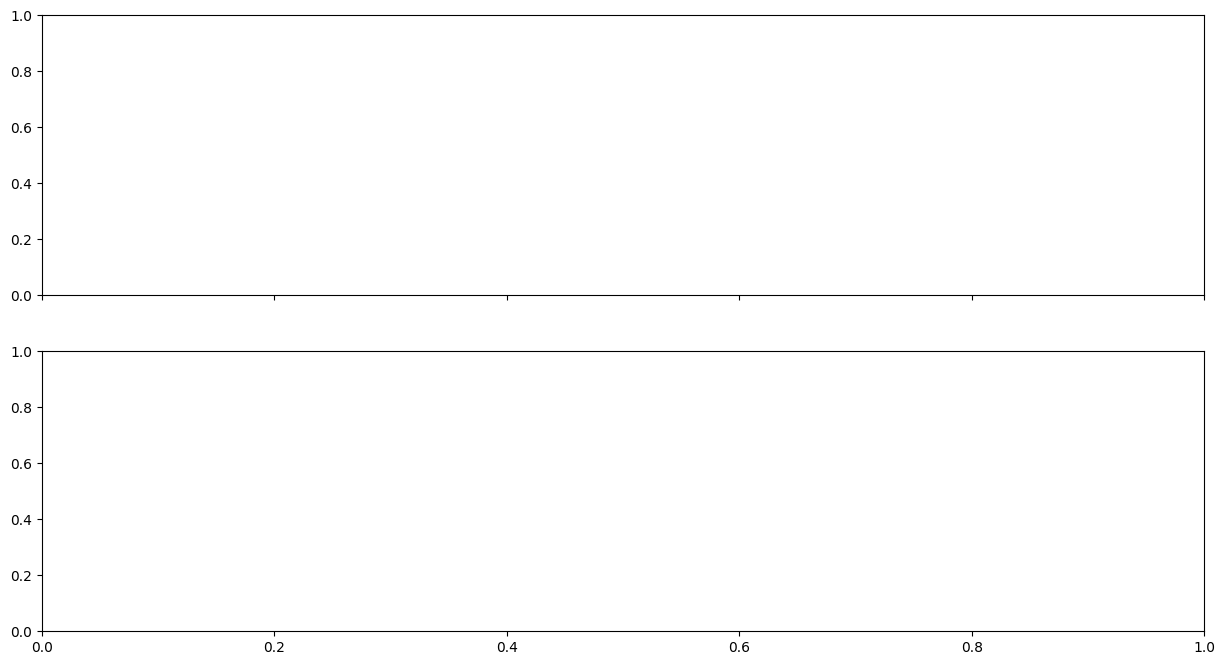

In [37]:
def __makeplot_mlti(_key):

    Nrow, Ncol = 2, 1

    font = 12

    ref_date = UTCDateTime(str(beatZ.times_utc.iloc[0])[:10])

    time_scaling = 1
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ[_key], color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    ax[0].plot(beatU.times_utc_sec*time_scaling, beatU[_key], color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")
    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV[_key], color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta f$ (Hz)", fontsize=font)

    n_rz, n_ru, n_rv = int(mltistats['Z']['cumsum'][-1]), int(mltistats['U']['cumsum'][-1]), int(mltistats['V']['cumsum'][-1])
    ax[1].plot(mltistats['Z']['tsec']*time_scaling, mltistats['Z']['cumsump'], color="tab:blue", label=f"RZ (N={n_rz})")
    ax[1].plot(mltistats['U']['tsec']*time_scaling, mltistats['U']['cumsump'], color="tab:green", label=f"RU (N={n_ru})")
    ax[1].plot(mltistats['V']['tsec']*time_scaling, mltistats['V']['cumsump'], color="tab:red", label=f"RV (N={n_rv})")

    ax[1].set_ylabel("MLTI Count (%)", fontsize=font)

    # ax[1].set_yscale("log")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    # ax[0].set_ylim(-0.07, 0.07)
    # ax[0].set_ylim(-0.07, 0.07)

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot_mlti("fj_reduced_masked");

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_mlti.png", format="png", dpi=150, bbox_inches='tight')


### load water level data

In [ ]:
from functions.load_water_level import __load_water_level

try:
    # load data
    pegel =  __load_water_level(config['tbeg'], config['tend'], path_to_data=lamont_path+"Pegel/")

    # remove error measurements with nan
    pegel['pegel'] = np.where(pegel.pegel <= 0, np.nan, pegel.pegel)

except:
    print(" -> pegel not loaded")


### load barometer data

In [ ]:
from andbro__read_sds import __read_sds

ffbi = __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDO", config['tbeg'], config['tend'])

ffbi.merge(fill_value="interpolate")

### load tiltmeter data

In [38]:
from functions.conversion_to_tilt import __conversion_to_tilt
from functions.read_yaml import __readYaml

In [39]:
# path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"
path_to_tilt = archive_path+"romy_archive/"

tromy0 = __read_sds(path_to_tilt, "BW.ROMYT..MAN", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAE", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAT", config['tbeg']-600, config['tend']+600)

# tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

tromy0 = __conversion_to_tilt(tromy0, confTilt['TROMY'])

NameError: name '__read_sds' is not defined

In [ ]:
tromy = tromy0.copy();

tromy = tromy.merge(fill_value="interpolate");

tromy = tromy.decimate(10, no_filter=False)
tromy = tromy.decimate(10, no_filter=False)

print(tromy)

tromy = tromy.trim(config['tbeg'], config['tend'])

for tr in tromy:
    tr.data = __reduce(tr.data, 10)

tromy.plot(equal_scale=False);


In [ ]:
# path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"
path_to_tilt = archive_path+"romy_archive/"

# load data
bromy0 =  __read_sds(path_to_tilt, "BW.DROMY..LAN", config['tbeg']-600, config['tend']+600)
bromy0 += __read_sds(path_to_tilt, "BW.DROMY..LAE", config['tbeg']-600, config['tend']+600)
bromy0 += __read_sds(path_to_tilt, "BW.DROMY..LAT", config['tbeg']-600, config['tend']+600)

# downsampling
bromy0 = bromy0.decimate(10, no_filter=False);
bromy0 = bromy0.decimate(10, no_filter=False);
bromy0 = bromy0.decimate(10, no_filter=False);
bromy0 = bromy0.decimate(4, no_filter=False);

# tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

bromy0 = __conversion_to_tilt(bromy0, confTilt['BROMY'])

bromy0 = bromy0.trim(config['tbeg'], config['tend']);

bromy = bromy0.copy();

bromy = bromy.merge(fill_value="interpolate");

bromy.plot(equal_scale=False);

del bromy0;

In [ ]:
Nsmooth = int(86400*tromy.select(channel="*N")[0].stats.sampling_rate)
tromyN_smooth = __smooth(tromy.select(channel="*N")[0].data, Nsmooth)
tromyE_smooth = __smooth(tromy.select(channel="*E")[0].data, Nsmooth)

bromyN_smooth = __reduce(bromy.select(channel="*N")[0].data, Nsmooth)
bromyE_smooth = __reduce(bromy.select(channel="*E")[0].data, Nsmooth)

In [ ]:
v0 = tromyN_smooth[~np.isnan(tromyN_smooth)][0]

if v0 > 0:
    tromyN_smooth += v0
else:
    tromyN_smooth -= v0


### Plotting

In [ ]:
def __makeplot_tilt_pegel_baro(_key1, _key2):

    Nrow, Ncol = 5, 1

    font = 12

    ref_date = UTCDateTime(str(beatZ.times_utc.iloc[0])[:10])

    time_scaling = 1

    tilt_scaling = 1e6

    fscale = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    f0_U = round(beatU.fj.iloc[0], 2)
    f0_V = round(beatV.fj.iloc[0], 2)
    f0_Z = round(beatZ.fj.iloc[0], 2)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ[_key1]/f0_Z*fscale,
               color="tab:blue", label=f"RZ (fo = {f0_Z} Hz)")
    # ax[0].plot(beatU.times_utc_sec*time_scaling, beatU[_key1]/f0_U*fscale,
    #            color="tab:green", label=f"RU (fo = {f0_U} Hz)")
    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV[_key1]/f0_V*fscale,
               color="tab:red", label=f"RV (fo = {f0_V} Hz)")

    ax[0].ticklabel_format(useOffset=False)
    # ax[0].set_ylabel("$\Delta$f (Hz)", fontsize=font)
    ax[0].set_ylabel("( $\delta$f - f$_o$ ) / f$_o$ (ppm)", fontsize=font)

    z0 = beatZ[_key2].dropna().iloc[0]
    u0 = beatU[_key2].dropna().iloc[0]
    v0 = beatV[_key2].dropna().iloc[0]

    fz, fv = -0.2, -0.2
    ax[1].plot(beatZ.times_utc_sec*time_scaling, fz*(beatZ[_key2]-z0)*tilt_scaling,
               color="tab:blue", label=f"{fz}x RZ")
    # ax[1].plot(beatU.times_utc_sec*time_scaling, -1*(beatU[_key2]-u0)*tilt_scaling,
    #            color="tab:green", label=f"-1x RU")
    ax[1].plot(beatV.times_utc_sec*time_scaling, fv*(beatV[_key2]-v0)*tilt_scaling,
               color="tab:red", label=f"{fv}x RV")
    # ax[1].set_ylim(-2, 7)

    ax[1].plot(tromy.select(channel="*N")[0].times(reftime=ref_date),
               tromyN_smooth*tilt_scaling,
               label="ROMYT",
               color="tab:orange", alpha=0.9, zorder=3, ls="--")

#     ax111 = ax[1].twinx()
#     # ax111.plot(bromy.select(channel="*N")[0].times(reftime=ref_date),
#     #            bromyN_smooth*tilt_scaling,
#     #            label="BROMY",
#     #            color="tab:orange", ls="--", alpha=0.9, zorder=3)
#     ax111.plot(tromy.select(channel="*N")[0].times(reftime=ref_date),
#                tromyN_smooth*tilt_scaling,
#                label="ROMYT",
#                color="tab:orange", alpha=0.9, zorder=3)

#     ax111.set_ylim(-1, 2)
#     ax111.set_yticks(np.linspace(ax111.get_yticks()[0], ax111.get_yticks()[-1], len(ax[1].get_yticks())))
#     ax111.yaxis.label.set_color('tab:orange')
#     ax111.tick_params(axis='y', colors='tab:orange')
#     ax111.set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)
#     ax111.legend(loc=4)

    ax[2].plot(pegel.times_utc - UTCDateTime(ref_date), pegel.pegel,
               label="water level",
               color="purple", alpha=0.9, zorder=3)


    ax[3].plot(ffbi.select(channel="*O")[0].times(reftime=UTCDateTime(ref_date)),
               ffbi.select(channel="*O")[0].data,
               label=f"{ffbi.select(channel='*O')[0].stats.station}.{ffbi.select(channel='*O')[0].stats.channel}",
               color="tab:red")

    n_rz, n_ru, n_rv = int(mltistats['Z']['cumsum'][-1]), int(mltistats['U']['cumsum'][-1]), int(mltistats['V']['cumsum'][-1])
    ax[4].plot(mltistats['Z']['tsec']*time_scaling, mltistats['Z']['cumsump'], color="tab:blue", label=f"RZ (N={n_rz})")
    # ax[4].plot(mltistats['U']['tsec']*time_scaling, mltistats['U']['cumsump'], color="tab:green", label=f"RU (N={n_ru})")
    ax[4].plot(mltistats['V']['tsec']*time_scaling, mltistats['V']['cumsump'], color="tab:red", label=f"RV (N={n_rv})")

    ax[1].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)
    ax[2].set_ylabel(f"Water Level (m)", fontsize=font)
    ax[3].set_ylabel(f"Air Pressure (hPa)", fontsize=font)
    ax[4].set_ylabel("Cum. MLTI (%)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        # ax[_n].legend(loc=1)

    ax[0].legend(loc=4)
    ax[0].legend(loc=7)
    ax[1].legend(loc=4)
    ax[2].legend(loc=1)
    ax[3].legend(loc=4)
    ax[4].legend(loc=4)

    ax[4].set_ylim(0, 102)

    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)', '(e)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    ax[0].set_title(f"mov. avg. {n_minutes} min")

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot_tilt_pegel_baro("fj_reduced_masked", "tilt_ns_reduced_masked");

fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_{str_key}_tilt_pegel_baro_mlti.png", format="png", dpi=150, bbox_inches='tight')


## As Stream

In [ ]:
def __sagnac_to_rads(data, ring):

    from numpy import pi, sqrt, arccos, deg2rad, sin, cos

    dip = {"Z":0, "U":109.5, "V":70.5, "W":70.5}

    L = {"Z":11.2, "U":12, "V":12, "W":12}

    ## Scale factor
    S = (sqrt(3)*L[ring])/(3*632.8e-9)

    ## ROMY latitude
    lat = 48.162941

    ## nominal Earth rotation
    omegaE = 2*pi/86400

    return data /S /sin(deg2rad(lat+dip[ring]))

In [ ]:
def __get_stream(dfU, dfV, dfZ, key, rotate=False):

    from functions.rotate_romy_ZUV_ZNE import __rotate_romy_ZUV_ZNE

    tr_beatU = Trace()
    tr_beatU.data = np.array(dfU[key])
    tr_beatU.stats.delta = 60
    tr_beatU.stats.starttime = UTCDateTime(str(dfU.times_utc.iloc[0]))
    tr_beatU.stats.network, tr_beatU.stats.station, tr_beatU.stats.channel = "BW", "ROMY", "LAU"

    tr_beatV = Trace()
    tr_beatV.data = np.array(dfV[key])
    tr_beatV.stats.delta = 60
    tr_beatV.stats.starttime = UTCDateTime(str(dfV.times_utc.iloc[0]))
    tr_beatV.stats.network, tr_beatV.stats.station, tr_beatV.stats.channel = "BW", "ROMY", "LAV"

    tr_beatZ = Trace()
    tr_beatZ.data = np.array(dfZ[key])
    tr_beatZ.stats.delta = 60
    tr_beatZ.stats.starttime = UTCDateTime(str(dfZ.times_utc.iloc[0]))
    tr_beatZ.stats.network, tr_beatZ.stats.station, tr_beatZ.stats.channel = "BW", "ROMY", "LAZ"

    st_tilt = Stream(traces=[tr_beatU, tr_beatV, tr_beatZ])

    etime = min(st_tilt[0].stats.endtime, st_tilt[1].stats.endtime, st_tilt[2].stats.endtime)
    st_tilt = st_tilt.trim(st_tilt[0].stats.starttime, etime)

    # rotate to ZNE system
    if rotate:
        path_to_inventory = root_path+"Documents/ROMY/stationxml_ringlaser/dataless/"

        romy_inv = read_inventory(path_to_inventory+"dataless.seed.BW_ROMY")

        st_tilt = __rotate_romy_ZUV_ZNE(st_tilt, romy_inv)

    return st_tilt

In [ ]:
st_beat = __get_stream(beatU, beatV, beatZ, "fj_reduced_masked", rotate=False)

In [ ]:
st_tilt = __get_stream(beatU, beatV, beatZ, "tilt_ns_reduced_masked", rotate=False)

In [ ]:
st_rad = st_beat.copy()

for tr in st_rad:
    tr.data = __sagnac_to_rads(tr.data, tr.stats.channel[-1])
    tr.data = __interpolate_nan(tr.data)

st_rad = __rotate_romy_ZUV_ZNE(st_rad, romy_inv)

st_rad = st_rad.integrate(method='cumtrapz')
# st_rad = st_rad.integrate(method='spline')

# import scipy.integrate as integrate
# for tr in st_rad:
#     tr.data = integrate.quad(tr.data, 0, len(tr.data))


st_rad.plot(equal_scale=False);

In [ ]:
plt.scatter(tromy.select(channel="*E")[0].data, tromy.select(channel="*N")[0].data, c=tromy.select(channel="*E")[0].times(),s=5)
# plt.scatter(st_tilt_zne.select(channel="*E")[0].data, st_tilt_zne.select(channel="*N")[0].data, c=st_tilt_zne.select(channel="*E")[0].times(), s=5)

plt.ylim(-1e-6, 1e-6)



In [ ]:
def __makeplot(_st):

    Nrow, Ncol = 2, 1

    font = 12

    # ref_date = UTCDateTime(str(beatZ.times_utc.iloc[0])[:10])
    ref_date = config['tbeg']

    time_scaling = 1
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.05)

    z = st_beat.select(channel="*Z")[0].data
    z0 = z[~np.isnan(z)][0]

    v = st_beat.select(channel="*V")[0].data
    v0 = v[~np.isnan(v)][0]

    u = st_beat.select(channel="*U")[0].data
    u0 = u[~np.isnan(u)][0]

    ax[0].plot(st_beat.select(channel="*Z")[0].times()*time_scaling, (z - z0)/z0,
               color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    ax[0].plot(st_beat.select(channel="*V")[0].times()*time_scaling, (v - v0)/v0,
               color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    ax[0].plot(st_beat.select(channel="*U")[0].times()*time_scaling, (u - u0)/u0,
               color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")

    ax[0].ticklabel_format(useOffset=False)
    # ax[0].set_ylabel("$\Delta$f (Hz)", fontsize=font)
    ax[0].set_ylabel("($\delta$f - fo) / fo", fontsize=font)


    ax[1].plot(_st.select(channel="*Z")[0].times()*time_scaling,
               _st.select(channel="*Z")[0].data*tilt_scaling,
               color="tab:blue", label=f"RZ")
    try:
        ax[1].plot(_st.select(channel="*N")[0].times()*time_scaling,
                   _st.select(channel="*N")[0].data*tilt_scaling,
                   color="tab:green", label=f"RN")
        ax[1].plot(_st.select(channel="*E")[0].times()*time_scaling,
                   _st.select(channel="*E")[0].data*tilt_scaling,
                   color="tab:red", label=f"RE")
    except:
        ax[1].plot(_st.select(channel="*U")[0].times()*time_scaling,
                   _st.select(channel="*U")[0].data*tilt_scaling,
                   color="tab:green", label=f"RU")
        ax[1].plot(_st.select(channel="*V")[0].times()*time_scaling,
                   _st.select(channel="*V")[0].data*tilt_scaling,
                   color="tab:red", label=f"RV")

    ax[1].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    # ax[0].set_ylim(-0.04, 0.04)

    ## add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    for _k, ll in enumerate(['(a)', '(b)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)

    plt.show();
    return fig

fig = __makeplot(st_tilt);

# fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_smoothed_asTilt.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
def __get_vector_movement(N, E, Twin=3600, ref_date=None, plot=False):

    from numpy import median, sqrt, arctan, degrees, mod, array, append, rad2deg, nan, ma, deg2rad

    dt = N[0].stats.delta
    t1 = 0

    Ndata = N[0].data
    Edata = E[0].data

    if ma.is_masked(Ndata):
        Ndata = ma.filled(Ndata, fill_value=nan)
    if ma.is_masked(Edata):
        Edata = ma.filled(Edata, fill_value=nan)

    vnorm, vdir, timeline = [], [], []
    while (t1 + Twin) < N[0].stats.npts*dt:

        Nmed = median(Ndata[int(t1/dt):int((t1+Twin)/dt)])
        Emed = median(Edata[int(t1/dt):int((t1+Twin)/dt)])


        vnorm.append(sqrt(Nmed**2 + Emed**2))

        if Nmed > 0 and Emed > 0:
            vdir.append(90-abs(rad2deg(arctan(abs(Nmed/Emed)))))

        elif Nmed < 0 and Emed > 0:
            vdir.append(90+abs(rad2deg(arctan(abs(Nmed/Emed)))))

        elif Nmed < 0 and Emed < 0:
            vdir.append(270-abs(rad2deg(arctan(abs(Nmed/Emed)))))

        elif Nmed > 0 and Emed < 0:
            vdir.append(270+abs(rad2deg(arctan(abs(Nmed/Emed)))))

        else:
            vdir.append(nan)

        t1 += Twin/2

        timeline.append(t1)

    if ref_date:
        time_offset = abs(UTCDateTime(ref_date) - N[0].stats.starttime)
    else:
        time_offset = 0

    vnorm = array(vnorm)
    vdir = array(vdir)
    timeline = (array(timeline) + time_offset)/3600 ## in hours


    ## Plotting ------------------------------------
    if plot:

        from numpy import deg2rad, arange, linspace
        import matplotlib.pyplot as plt

        vnorm = vnorm
        vdirection = vdir

        ## times to days
        times = timeline /24

        time_min = min(times)
        time_max = max(times)

        ## Plot --------------------------------------------------------------------------
        fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'), figsize=(5, 5))

        font = 12

        cmap = plt.get_cmap('viridis')

        vscaling, vunit = 1e3, "mrad"

        ## convert degrees to radians for plotting as polar!
        p0 = ax.scatter(deg2rad(vdirection), vnorm*vscaling, c=times, cmap=cmap,
                        vmin=time_min, vmax=time_max, alpha=0.75, s=4, zorder=2)

        cbar = plt.colorbar(p0, ax=ax,  pad=0.1, orientation='vertical', fraction=0.1, shrink=.8)

        if ref_date:
            cbar.set_label('Time (days)', rotation=90, fontsize=font, labelpad=10)
        else:
            cbar.set_label(f'Time from {ref_date} (days)', rotation=90, fontsize=font, labelpad=10)

        ## set new colorbar ticks
        # ref_time = config['tbeg']
        # nticks = [str((ref_time+time_min+t*86400).date) for t in cbar.get_ticks()]
        # cbar.set_ticklabels(nticks)

        vmax = round(max(vnorm*vscaling) * 1.1, 0)

        ax.set_ylim(0, vmax)
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)

        ax.text(deg2rad(25), vmax*1.2, f"({vunit})")
        ax.set_rgrids(linspace(0., vmax, 5), angle=25., zorder=0)

        ax.set_title("Tilt of ROMY structure", fontsize=font)

        plt.show();

    return timeline, vdir, vnorm

In [ ]:
def __makeplot_normal_vector_movement(times, vdirection, vnorm, ref_date=None):

    from numpy import deg2rad, arange, linspace
    import matplotlib.pyplot as plt

    ## times to days
    times = times /24

    time_min = min(times)
    time_max = max(times)

    ## Plot --------------------------------------------------------------------------
    fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'), figsize=(5, 5))

    font = 12

    cmap = plt.get_cmap('viridis')

    vscaling, vunit = 1e3, "mrad"

    ## convert degrees to radians for plotting as polar!
    p0 = ax.scatter(deg2rad(vdirection), vnorm*vscaling, c=times, cmap=cmap,
                    vmin=time_min, vmax=time_max, alpha=0.75, s=4, zorder=2)

    cbar = plt.colorbar(p0, ax=ax,  pad=0.1, orientation='vertical', fraction=0.1, shrink=.8)

    if ref_date is not None:
        cbar.set_label('Time (days)', rotation=90, fontsize=font, labelpad=10)
    else:
        cbar.set_label(f'Time from {ref_date} (days)', rotation=90, fontsize=font, labelpad=10)

    ## set new colorbar ticks
    # ref_time = config['tbeg']
    # nticks = [str((ref_time+time_min+t*86400).date) for t in cbar.get_ticks()]
    # cbar.set_ticklabels(nticks)

    vmax = round(max(vnorm*vscaling) * 1.1, 0)

    ax.set_ylim(0, vmax)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

    ax.text(deg2rad(25), vmax*1.2, f"({vunit})")
    ax.set_rgrids(linspace(0., vmax, 5), angle=25., zorder=0)

    ax.set_title("Tilt of ROMY structure", fontsize=font)

    plt.show();
    return fig

In [ ]:
twindow = 3600  # seconds

ttimes, vector_direction, vector_norm = __get_vector_movement(st_rad.select(channel="*N"),
                                                              st_rad.select(channel="*E"),
                                                              Twin=twindow,
                                                              plot=False,
                                                              )


In [ ]:
fig = __makeplot_normal_vector_movement(ttimes, vector_direction, vector_norm, ref_date=st_rad[0].stats.starttime.date)

# fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}_vector_movement.png", format="png", dpi=150, bbox_inches='tight')


## Tides

In [ ]:
st_beat_zne_tide = st_beat_zne.copy();

for tr in st_beat_zne_tide:
    tr.data = __interpolate_nan(tr.data)

## daily
# f1 = 1/(25*3600)
# f2 = 1/(23*3600)

## sub-daily
f1 = 1/(13*3600)
f2 = 1/(11*3600)

st_beat_zne_tide.detrend("linear")
st_beat_zne_tide.taper(0.1)
st_beat_zne_tide.filter("bandpass", freqmin=f1, freqmax=f2, corners=4, zerophase=True)

st_beat_zne_tide.plot(equal_scale=False);


### Load Tilt Data

In [ ]:
from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from functions.conversion_to_tilt import __conversion_to_tilt

In [ ]:
path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"
path_to_tilt = archive_path+"romy_archive/"

# sta, cha, name = "TROMY", "MA", "TROMY"
sta, cha, name = "DROMY", "LA", "BROMY"

tilt =  __read_sds(path_to_tilt, f"BW.{sta}..{cha}T", config['tbeg']-600, config['tend']+600)
tilt += __read_sds(path_to_tilt, f"BW.{sta}..{cha}N", config['tbeg']-600, config['tend']+600)
tilt += __read_sds(path_to_tilt, f"BW.{sta}..{cha}E", config['tbeg']-600, config['tend']+600)

## tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

tilt = __conversion_to_tilt(tilt, confTilt[f'{name}'])

tilt = tilt.trim(config['tbeg'], config['tend'])

tilt.plot(equal_scale=False);

gc.collect();

In [ ]:
tides = Stream()

tides += st_rad.copy()
tides += tilt.copy()

tides = tides.resample(0.005, no_filter=False);

# f1, f2 = 1/(15*3600), 1/(11*3600)
# f1, f2 = 1/(25*3600), 1/(23*3600)

# tides = tides.detrend("simple")
# tides = tides.taper(0.01)
# tides = tides.filter("bandpass", freqmin=f1, freqmax=f2, corners=4, zerophase=True)

# tides.merge();

tides.plot(equal_scale=False);

In [ ]:
def __makeplot_tides():


    f1_subdaily, f2_subdaily = 1/(13*3600), 1/(11*3600)

    f1_daily, f2_daily = 1/(25*3600), 1/(23*3600)

    _detrend="simple"
    _taper = 0.05
    corners = 2

    tiltmeter="TROMY"

    tides_daily = tides.copy()
    tides_daily = tides_daily.detrend(_detrend)
    tides_daily = tides_daily.taper(_taper, type="cosine")
    tides_daily = tides_daily.filter("bandpass", freqmin=f1_daily, freqmax=f2_daily, corners=corners, zerophase=False)
    # tides_daily = tides_daily.filter("bandpass", freqmin=f1_daily, freqmax=f2_daily, corners=corners, zerophase=True)

    tides_subdaily = tides.copy()
    tides_subdaily = tides_subdaily.detrend(_detrend)
    tides_subdaily = tides_subdaily.taper(_taper, type="cosine")
    tides_subdaily = tides_subdaily.filter("bandpass", freqmin=f1_subdaily, freqmax=f2_subdaily, corners=corners, zerophase=False)
    # tides_subdaily = tides_subdaily.filter("bandpass", freqmin=f1_subdaily, freqmax=f2_subdaily, corners=corners, zerophase=True)


    Nrow, Ncol = 2, 2

    font = 12

    time_scaling, time_unit = 1/86400, "days"
    tilt_scaling, tilt_unit = 1e9, "nrad"

    ref_time = config['tbeg']-86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0,0].plot(tides_subdaily.select(station=tiltmeter, channel="*N")[0].times(reftime=ref_time)*time_scaling,
                 tides_subdaily.select(station=tiltmeter, channel="*N")[0].data*tilt_scaling,
                 color="black", label=f"N-S {tiltmeter}", lw=1)

    ax[1,0].plot(tides_subdaily.select(station=tiltmeter, channel="*E")[0].times(reftime=ref_time)*time_scaling,
                 tides_subdaily.select(station=tiltmeter, channel="*E")[0].data*tilt_scaling,
                 color="black", label=f"E-W {tiltmeter}", lw=1)

    ax[0,1].plot(tides_daily.select(station=tiltmeter, channel="*N")[0].times(reftime=ref_time)*time_scaling,
                 tides_daily.select(station=tiltmeter, channel="*N")[0].data*tilt_scaling,
                 color="black", label=f"N-S {tiltmeter}", lw=1)

    ax[1,1].plot(tides_daily.select(station=tiltmeter, channel="*E")[0].times(reftime=ref_time)*time_scaling,
                 tides_daily.select(station=tiltmeter, channel="*E")[0].data*tilt_scaling,
                 color="black", label=f"E-W {tiltmeter}", lw=1)

    ax00 = ax[0,0].twinx()
    ax10 = ax[1,0].twinx()
    ax01 = ax[0,1].twinx()
    ax11 = ax[1,1].twinx()


    ax00.plot(tides_subdaily.select(station="ROMY", channel="*N")[0].times(reftime=ref_time)*time_scaling,
                 tides_subdaily.select(station="ROMY", channel="*N")[0].data*tilt_scaling,
                 color="darkred", label="N-S (ring)", lw=1)

    ax10.plot(tides_subdaily.select(station="ROMY", channel="*E")[0].times(reftime=ref_time)*time_scaling,
                 tides_subdaily.select(station="ROMY", channel="*E")[0].data*tilt_scaling,
                 color="darkred", label="E-W (ring)", lw=1)

    ax01.plot(tides_daily.select(station="ROMY", channel="*N")[0].times(reftime=ref_time)*time_scaling,
                 tides_daily.select(station="ROMY", channel="*N")[0].data*tilt_scaling,
                 color="darkred", label="N-S (ring)", lw=1)

    ax11.plot(tides_daily.select(station="ROMY", channel="*E")[0].times(reftime=ref_time)*time_scaling,
                 tides_daily.select(station="ROMY", channel="*E")[0].data*tilt_scaling,
                 color="darkred", label="E-W (ring)", lw=1)


    ax[0,0].set_ylabel(f"Tilt ({tilt_unit})", fontsize=font)
    ax[1,0].set_ylabel(f"Tilt ({tilt_unit})", fontsize=font)
    ax01.set_ylabel(f"Tilt ({tilt_unit})", fontsize=font, color="darkred")
    ax11.set_ylabel(f"Tilt ({tilt_unit})", fontsize=font, color="darkred")

    ax[1,0].set_xlabel(f"Time (days) from {config['tbeg'].date} {config['tbeg'].time} UTC", fontsize=font)
    ax[1,1].set_xlabel(f"Time (days) from {config['tbeg'].date} {config['tbeg'].time} UTC", fontsize=font)

    ax[0,0].set_ylim(-60, 60)
    ax[0,1].set_ylim(-40, 40)
    ax[1,0].set_ylim(-100, 100)
    ax[1,1].set_ylim(-50, 50)

    ax[0,0].set_title(f"T={round(1/f2_subdaily/3600,1)} - {round(1/f1_subdaily/3600,1)}h", fontsize=font+1)
    ax[0,1].set_title(f"T={round(1/f2_daily/3600,1)} - {round(1/f1_daily/3600,1)}h", fontsize=font+1)

    ticks = []
    for _i in range(Nrow):
        for _j in range(Ncol):
            ax[_i,_j].grid(ls=":", zorder=0)
            ax[_i,_j].legend(loc=1)
            ticks.append(ax[_i,_j].get_yticks())


    for ax in [ax00, ax10, ax01, ax11]:
        ax.tick_params(axis='y', colors='darkred')
        ax.legend(loc=4)

    ax00.set_yticks(np.linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ticks[0])))
    ax10.set_yticks(np.linspace(ax10.get_yticks()[0], ax10.get_yticks()[-1], len(ticks[2])))
    ax01.set_yticks(np.linspace(ax01.get_yticks()[0], ax01.get_yticks()[-1], len(ticks[1])))
    ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ticks[3])))


#     ## add dates to x-axis
#     ref_date = UTCDateTime(config['tbeg'])
#     tcks = ax[Nrow-1].get_xticks()
#     tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
#     ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot_tides();

